In [1]:
from io import BytesIO
from urllib import parse

import requests
import pandas as pd
import typing
import folium
import numpy as np

In [2]:
sheet_id = "1Du85UwjvCwPuzWOaHpZzYwcozYOWA30N"
sheet_name = "Table 1"

sheet_id = parse.quote(sheet_id)
sheet_name = parse.quote(sheet_name)
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [3]:
print("Fetching from")
print(url)
df = pd.read_csv(url)

Fetching from
https://docs.google.com/spreadsheets/d/1Du85UwjvCwPuzWOaHpZzYwcozYOWA30N/gviz/tq?tqx=out:csv&sheet=Table%201


In [ ]:
for _, loc in (df[["Latitude", "Longitude"]]).iterrows():
    print(loc['Latitude'], loc['Longitude'])

## 1. Mere plotting

Functions useful for the next plot.

In [6]:
def get_colors(cluster_count: int) -> typing.List[str]:
    from matplotlib import colors, cm
    x = np.arange(cluster_count)
    ys = [i + x + (i*x)**2 for i in range(cluster_count)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    return [colors.rgb2hex(i) for i in colors_array]

In [7]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    ret_rgb = colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

    from matplotlib import colors
    return colors.to_hex(ret_rgb)

In [8]:
import folium

def mere_plot():
    m = folium.Map(location=[42.639249,-71.3223647], zoom_start=13)
    colors = ["#FF3300"]

    for _, loc in (df[["Latitude", "Longitude"]]).iterrows():
        lati = loc["Latitude"]
        long = loc["Longitude"]
        if not pd.isnull(lati):
            folium.Circle(location=(lati, long),
                          radius=150,
                          color=colors[0],
                          opacity=0.0,
                          fill=True,
                          fill_color=colors[0],
                          fill_opacity=0.15).add_to(m)
    return m

mere_plot()

## 2. Plot using zipcode info

In [9]:
import folium

def plot_by_zipcode():
    m = folium.Map(location=[42.639249,-71.3223647], zoom_start=13)

    grouped = df[["Latitude", "Longitude", "Zipcode"]].groupby("Zipcode")
    zipcode_count = len(list(grouped))

    colors = [lighten_color(c, 1.2) for c in get_colors(zipcode_count)]

    zip_index = 0
    for zip_name, group_data in grouped:
        for i, loc in group_data.iterrows():
            lati = loc["Latitude"]
            long = loc["Longitude"]
            if not pd.isnull(lati):
                folium.CircleMarker(location=(lati, long),
                              radius=5,
                              color=colors[zip_index],
                              fill=True,
                              opacity=0.0,
                              fill_color=colors[zip_index],
                              fill_opacity=1,
                              tooltip=zip_name).add_to(m)
        # break
        zip_index += 1
    return m

plot_by_zipcode()

In [45]:
test = df[["Latitude", "Longitude", "Zipcode"]]
test.dropna()
code = test.Zipcode.unique()
test.groupby("Zipcode").count()

Latitude  Longitude
Zipcode                      
MA 01826         1          1
MA 01850       237        237
MA 01851       196        196
MA 01852       537        537
MA 01854       249        249

## 3. Direct clustering

In [ ]:
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as hierarchy

import typing

In [ ]:
def run_kmeans(data: np.ndarray, k: int) -> KMeans:
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init = 10)
    kmeans.fit_predict(data)
    return kmeans

In [ ]:
def cluster_kmeans(data: np.ndarray,
                   min_k: int = 2,
                   max_k: int = 10) -> typing.Tuple[np.ndarray, np.ndarray]:
    errors = np.zeros(max_k + 1)
    sil_errors = np.zeros(max_k + 1)

    for k in tqdm(range(min_k, max_k + 1)):
        kmeans = run_kmeans(data, k)
        errors[k] = kmeans.inertia_
        sil_errors[k] = silhouette_score(data, kmeans.labels_, metric = 'euclidean')

    return errors, sil_errors

In [ ]:
def plot_error(data: np.ndarray, title: str, label: str,
               min_k: int, max_k: int):
    plt.plot(range(min_k, min(max_k, len(data))), data[min_k:max_k], 'o-')
    plt.xlabel('Number of Clusters')
    plt.title(title)
    plt.ylabel(label)
    plt.show()

100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


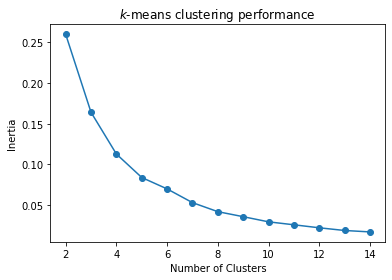

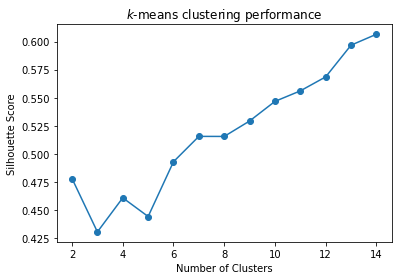

In [ ]:
def try_kmeans(low=2, upp=20):
    lati_long = df[["Latitude", "Longitude"]]
    lati_long = lati_long[lati_long['Latitude'].notna()]
    lati_long = lati_long[lati_long['Longitude'].notna()]

    intertia, sil = cluster_kmeans(lati_long, low, upp)

    plot_error(intertia, '$k$-means clustering performance',
           'Inertia', low, upp)

    plot_error(sil, '$k$-means clustering performance',
           'Silhouette Score', low, upp)

try_kmeans(2, 15)

As can be seen from the above content, we can try clustering or when $k=2$ and $k=5$.

In [ ]:
import folium

def draw_lowell_kmeans(k=2):
    m = folium.Map(location=[42.639249,-71.3223647], zoom_start=13)

    lati_long = df[["Latitude", "Longitude"]]
    lati_long = lati_long[lati_long['Latitude'].notna()]
    lati_long = lati_long[lati_long['Longitude'].notna()]

    colors = get_colors(k)
    lighten_colors = [lighten_color(c, 0.5) for c in colors]
    darken_colors = [lighten_color(c, 1.5) for c in colors]

    # train the cluster
    kmeans = run_kmeans(lati_long, k)
    results = kmeans.predict(lati_long)

    for (i, loc), label in zip(lati_long.iterrows(), results):
        lati = loc["Latitude"]
        long = loc["Longitude"]
        folium.Circle(location=(lati, long),
                      radius=120,
                      color=colors[label],
                      opacity=0,
                      fill=True,
                      fill_color=colors[label],
                      fill_opacity=0.4).add_to(m)

    for i, center in enumerate(kmeans.cluster_centers_):
        lati, long = center
        folium.Circle(location=(lati, long),
                      radius=300,
                      color=lighten_colors[i],
                      fill=True,
                      fill_color=darken_colors[i],
                      fill_opacity=1.0,
                      tooltip=f"Cluster #{i+1}:" + "(%.4f, %.4f)" % (lati, long)).add_to(m)

    return m

On $k=2$:

In [ ]:
draw_lowell_kmeans(2)

On $k=5$:

In [ ]:
draw_lowell_kmeans(5)

## 4. HeatMap

In [ ]:
def make_heat_map():
    import folium
    m = folium.Map(location=[42.639249,-71.3223647], zoom_start=13)
    
    lati_long = df[["Latitude", "Longitude"]]
    lati_long = lati_long[lati_long['Latitude'].notna()]
    lati_long = lati_long[lati_long['Longitude'].notna()]
    lati_long["temp"] = 400 / lati_long.shape[0]

    from folium.plugins import HeatMap
    HeatMap(lati_long.to_numpy(), min_opacity=0.2).add_to(m)
    return m

make_heat_map()

In [ ]:
merge_df = pd.read_csv("merge.csv")

In [ ]:
merge_df

Issuing Agency  OfficerID  ...  Longitude   Zipcode
0     Lowell Police Dept.      841.0  ...        NaN       NaN
1     Lowell Police Dept.      773.0  ... -71.306738  MA 01852
2     Lowell Police Dept.      783.0  ... -71.308926  MA 01852
3     Lowell Police Dept.      569.0  ... -71.308351  MA 01850
4     Lowell Police Dept.    15765.0  ... -71.304718  MA 01852
...                   ...        ...  ...        ...       ...
2078                  NaN        NaN  ... -71.324888  MA 01851
2079                  NaN        NaN  ... -71.324888  MA 01851
2080                  NaN        NaN  ... -71.314748  MA 01850
2081                  NaN        NaN  ... -71.355022  MA 01851
2082                  NaN        NaN  ... -71.355022  MA 01851

[2083 rows x 22 columns]

In [ ]:
def make_heat_map_race(df):
    m = folium.Map(location=[42.639249,-71.3223647], zoom_start=13)
    
    lati_long = df[["Latitude", "Longitude"]]
    lati_long = lati_long[lati_long['Latitude'].notna()]
    lati_long = lati_long[lati_long['Longitude'].notna()]
    lati_long["temp"] = 400 / lati_long.shape[0]

    from folium.plugins import HeatMap
    HeatMap(lati_long.to_numpy(), min_opacity=0.2).add_to(m)
    return m

In [ ]:
hisp_df = merge_df.loc[merge_df['Race'] == "HISP"]
black_df = merge_df.loc[merge_df['Race'] == "BLACK"]
asian_df = merge_df.loc[merge_df['Race'] == "ASIAN"]
white_df = merge_df.loc[merge_df['Race'] == "WHITE"]

In [ ]:
make_heat_map_race(hisp_df)

In [ ]:
make_heat_map_race(black_df)

In [ ]:
make_heat_map_race(white_df)

In [ ]:
make_heat_map_race(asian_df)